# Header-Based Markdown Chunking for RAG System

This notebook implements a header-based chunking strategy specifically optimized for Markdown content. Instead of using fixed-size chunking, we'll create semantically coherent chunks based on the document's header structure (## and ### headings), which preserves the natural organization of the content.

In [92]:
# Import required libraries
import os
import json
import time
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import logging
from datetime import datetime

# Import LangChain's Document object for compatibility with vector stores
from langchain_core.documents import Document

In [93]:
# --- Configuration ---
# Input directory for markdown files
INPUT_MARKDOWN_DIR = "../data/markdown_clean_final"
# Output directory for chunked JSON files
OUTPUT_CHUNKS_DIR = "../data/chunks_v2"
# Output directory for log files
LOGS_DIR = "../logs"

# Create directories if they don't exist
Path(OUTPUT_CHUNKS_DIR).mkdir(parents=True, exist_ok=True)
Path(LOGS_DIR).mkdir(parents=True, exist_ok=True)

In [94]:
# Set up logging
log_file = Path(LOGS_DIR) / f"header_chunking_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(module)s - %(funcName)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file, encoding='utf-8'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [95]:
def parse_frontmatter(content):
    """
    Parse markdown frontmatter without external YAML dependencies.
    
    Args:
        content (str): Markdown content with YAML frontmatter
        
    Returns:
        tuple: (metadata_dict, content_without_frontmatter)
    """
    if not content.startswith('---'):
        logger.debug("No frontmatter found (doesn't start with '---').")
        return {}, content
    
    parts = content.split('---', 2)
    if len(parts) < 3:
        logger.debug("Invalid frontmatter structure (not enough '---' separators).")
        return {}, content # Not a valid frontmatter structure
    
    frontmatter_text = parts[1].strip()
    content_text = parts[2].strip() # The rest of the document
    
    metadata = {}
    for line in frontmatter_text.splitlines():
        line = line.strip()
        if not line or ':' not in line:
            continue
        
        key, value = line.split(':', 1)
        key = key.strip()
        value = value.strip()
        
        # Remove quotes if present (handles both single and double)
        if (value.startswith('"') and value.endswith('"')) or \
           (value.startswith("'") and value.endswith("'")):
            value = value[1:-1]
            
        metadata[key] = value
    
    logger.debug(f"Parsed frontmatter: {metadata}")
    return metadata, content_text

In [96]:
def extract_file_category(file_path):
    """
    Extract category from file path based on filename pattern.
    For example: people_*.md -> 'people', news_*.md -> 'news', etc.
    """
    file_name = Path(file_path).name
    parts = file_name.split('_')
    if len(parts) > 0:
        return parts[0]
    return "unknown"

In [97]:
# ── Hybrid header-aware + size-fallback splitter ──────────────────────
def split_markdown_by_headers(
        file_path,
        header_levels: tuple[int, ...] = (1, 2, 3, 4, 5, 6),
        chunk_size: int = 400,
        chunk_overlap: int = 50,
):
    """
    Read one Markdown file and return a list of LangChain Document chunks.
    1. Keep YAML front-matter as metadata.
    2. Primary split on headings (#–######) whose level is in `header_levels`.
    3. For any resulting section > `chunk_size` tokens *or* for files with
       no qualifying headings, fall back to MarkdownTextSplitter so no chunk
       exceeds `chunk_size`.
    """
    from langchain.text_splitter import MarkdownTextSplitter
    import unicodedata, re, tiktoken                     # token counter

    file_path = Path(file_path)
    logger.info(f"Processing file: {file_path.name}")

    # ── read file ────────────────────────────────────────────────────────
    try:
        raw_text = file_path.read_text(encoding="utf-8")
    except Exception as e:
        logger.error(f"Could not read {file_path}: {e}")
        return []

    # ── parse YAML front-matter -----------------------------------------
    meta, body = parse_frontmatter(raw_text)             # uses your helper
    meta.update({
        "source_file": str(file_path.resolve()),
        "filename": file_path.name,
        "category": extract_file_category(file_path)
    })

    body = unicodedata.normalize("NFKC", body.strip())

    # ── heading regex ----------------------------------------------------
    hdr_rx = re.compile(
        rf"^({'|'.join('#' * lvl for lvl in header_levels)})\s+(.*)",
        re.M
    )

    # ── helper splitter --------------------------------------------------
    mdl_splitter = MarkdownTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    enc = tiktoken.encoding_for_model("gpt-3.5-turbo")   # fast token count

    def too_big(txt: str) -> bool:
        return len(enc.encode(txt)) > chunk_size

    # ── iterate & build chunks ------------------------------------------
    chunks, buf, cur_hdr = [], [], None
    chunk_id = 0

    def flush_buffer():
        nonlocal chunk_id
        if not buf:
            return
        section_text = "\n".join(buf).strip()
        if not section_text:
            return

        # size-split if needed
        sub_chunks = mdl_splitter.split_text(section_text) if too_big(section_text) else [section_text]

        for idx, sub in enumerate(sub_chunks):
            cm = meta.copy()
            if cur_hdr:
                cm["section"]   = cur_hdr
            cm["chunk_id"]      = f"{file_path.stem}_{chunk_id}"
            cm["section_level"] = "header" if cur_hdr else "document"
            cm["header_text"]   = cur_hdr
            cm["header_level"]  = len(cur_hdr.split()[0].lstrip('#')) if cur_hdr else 0
            doc = Document(page_content=sub, metadata=cm)
            chunks.append(doc)
            chunk_id += 1

    for line in body.splitlines():
        m = hdr_rx.match(line)
        if m:
            flush_buffer()
            cur_hdr = line  # keep full header line (e.g., "## Core Courses")
            buf = [line]
        else:
            buf.append(line)
    flush_buffer()

    # fallback for docs with *no* headings at all
    if not chunks:
        logger.warning(f"No qualifying headers in {file_path.name}; using size splitter")
        for sub in mdl_splitter.split_text(body):
            cm = meta.copy()
            cm.update({
                "section_level": "document",
                "chunk_id": f"{file_path.stem}_{chunk_id}"
            })
            chunks.append(Document(page_content=sub, metadata=cm))
            chunk_id += 1

    logger.info(f"{file_path.name}: {len(chunks)} chunks")
    return chunks


In [98]:
def process_markdown_directory(input_dir_path_str, output_dir_path_str):
    """
    Process all markdown files in a directory, chunk them by headers, and save the chunks.
    """
    input_path = Path(input_dir_path_str)
    output_path = Path(output_dir_path_str)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Find all markdown files
    markdown_files = list(input_path.rglob("*.md"))
    logger.info(f"Found {len(markdown_files)} markdown files in '{input_path}' and its subdirectories")
    
    if not markdown_files:
        logger.warning(f"No markdown files found in {input_path}. Exiting.")
        return 0, 0
    
    all_chunks_list = []
    total_files_processed = 0
    
    # Process each markdown file
    for md_file in tqdm(markdown_files, desc="Processing Markdown Files"):
        chunks = split_markdown_by_headers(md_file)
        
        if chunks:
            total_files_processed += 1
            
            # Convert Document objects to dictionaries for JSON serialization
            chunks_serializable = []
            for chunk in chunks:
                if isinstance(chunk, Document):
                    chunks_serializable.append({
                        "page_content": chunk.page_content,
                        "metadata": chunk.metadata
                    })
                else:  # Already a dict (fallback case)
                    chunks_serializable.append(chunk)
            
            # Add to the consolidated list
            all_chunks_list.extend(chunks_serializable)
            
            # Save individual file chunks
            # Create mirrored directory structure
            relative_path = md_file.relative_to(input_path)
            output_dir = output_path / relative_path.parent
            output_dir.mkdir(parents=True, exist_ok=True)
            
            # Save to individual JSON file
            output_json_path = output_dir / f"{md_file.stem}_chunks_v2.json"
            try:
                with open(output_json_path, "w", encoding="utf-8") as f:
                    json.dump(chunks_serializable, f, indent=2, ensure_ascii=False)
                logger.info(f"Saved {len(chunks_serializable)} chunks for {md_file.name} to {output_json_path}")
            except Exception as e:
                logger.error(f"Error saving chunks for {md_file.name}: {e}")
    
    # Save all chunks to a consolidated file
    if all_chunks_list:
        all_chunks_file = output_path / "all_chunks_by_header_v2.json"
        try:
            with open(all_chunks_file, "w", encoding="utf-8") as f:
                json.dump(all_chunks_list, f, indent=2, ensure_ascii=False)
            logger.info(f"Saved all {len(all_chunks_list)} chunks to {all_chunks_file}")
        except Exception as e:
            logger.error(f"Error saving consolidated chunks file: {e}")
    
    return total_files_processed, len(all_chunks_list)

In [99]:
def analyze_chunks(all_chunks_file):
    """
    Analyze the distribution of chunks to provide insights on the chunking results.
    """
    all_chunks_path = Path(all_chunks_file)
    if not all_chunks_path.exists():
        logger.error(f"Consolidated chunks file not found: {all_chunks_path}")
        return None
    
    try:
        with open(all_chunks_path, "r", encoding="utf-8") as f:
            chunks_data = json.load(f)
    except Exception as e:
        logger.error(f"Error loading chunks file: {e}")
        return None
    
    if not chunks_data:
        logger.warning("No chunks found for analysis")
        return None
    
    # Extract data for analysis
    chunk_lengths = [len(chunk["page_content"]) for chunk in chunks_data]
    categories = [chunk["metadata"].get("category", "unknown") for chunk in chunks_data]
    section_levels = [chunk["metadata"].get("section_level", "unknown") for chunk in chunks_data]
    header_levels = [chunk["metadata"].get("header_level", 0) for chunk in chunks_data]
    
    # Create DataFrame for analysis
    df = pd.DataFrame({
        "length": chunk_lengths,
        "category": categories,
        "section_level": section_levels,
        "header_level": header_levels
    })
    
    # Basic statistics
    logger.info(f"\n--- Chunk Analysis ---")
    logger.info(f"Total chunks: {len(chunks_data)}")
    logger.info(f"Average chunk length: {df['length'].mean():.2f} characters")
    logger.info(f"Median chunk length: {df['length'].median():.2f} characters")
    logger.info(f"Min chunk length: {df['length'].min()} characters")
    logger.info(f"Max chunk length: {df['length'].max()} characters")
    
    # Distribution by category
    category_counts = df["category"].value_counts()
    logger.info("\nCategory distribution:")
    for category, count in category_counts.items():
        logger.info(f"  - {category}: {count} chunks")
    
    # Distribution by section level
    section_level_counts = df["section_level"].value_counts()
    logger.info("\nSection level distribution:")
    for level, count in section_level_counts.items():
        logger.info(f"  - {level}: {count} chunks")
    
    # Visualizations
    # 1. Chunk length distribution
    plt.figure(figsize=(12, 6))
    plt.hist(chunk_lengths, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Chunk Lengths')
    plt.xlabel('Chunk Length (characters)')
    plt.ylabel('Number of Chunks')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    # 2. Category distribution
    plt.figure(figsize=(14, 7))
    category_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
    plt.title('Number of Chunks by Category')
    plt.xlabel('Category')
    plt.ylabel('Number of Chunks')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 3. Section level distribution
    plt.figure(figsize=(10, 6))
    section_level_counts.plot(kind='bar', color='salmon', edgecolor='black')
    plt.title('Number of Chunks by Section Level')
    plt.xlabel('Section Level')
    plt.ylabel('Number of Chunks')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return df

2025-05-12 17:54:55,215 - INFO - 2616926972 - <module> - --- Starting Header-Based Markdown Chunking Process ---
2025-05-12 17:54:55,219 - INFO - 1566263932 - process_markdown_directory - Found 79 markdown files in '../data/markdown_clean_final' and its subdirectories


Processing Markdown Files:   0%|          | 0/79 [00:00<?, ?it/s]

2025-05-12 17:54:55,223 - INFO - 3331294721 - split_markdown_by_headers - Processing file: education_masters-programs_ms-in-applied-data-science_course-progressions.md
2025-05-12 17:54:55,227 - INFO - 3331294721 - split_markdown_by_headers - education_masters-programs_ms-in-applied-data-science_course-progressions.md: 58 chunks
2025-05-12 17:54:55,229 - INFO - 1566263932 - process_markdown_directory - Saved 58 chunks for education_masters-programs_ms-in-applied-data-science_course-progressions.md to ../data/chunks_v2/education_masters-programs_ms-in-applied-data-science_course-progressions_chunks_v2.json
2025-05-12 17:54:55,230 - INFO - 3331294721 - split_markdown_by_headers - Processing file: news_masters-in-applied-data-science-summer-2024-capstone-winners.md
2025-05-12 17:54:55,231 - INFO - 3331294721 - split_markdown_by_headers - news_masters-in-applied-data-science-summer-2024-capstone-winners.md: 8 chunks
2025-05-12 17:54:55,232 - INFO - 1566263932 - process_markdown_directory - 

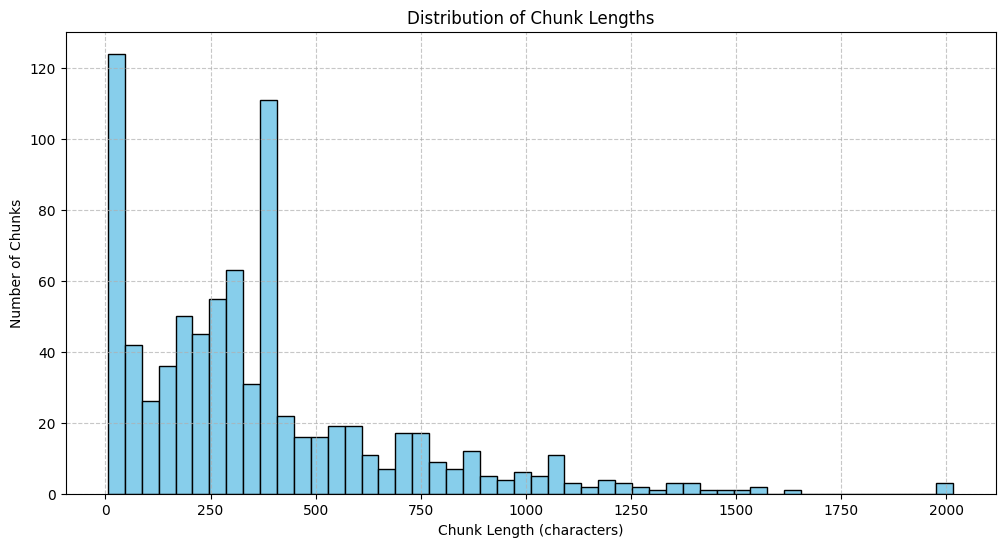

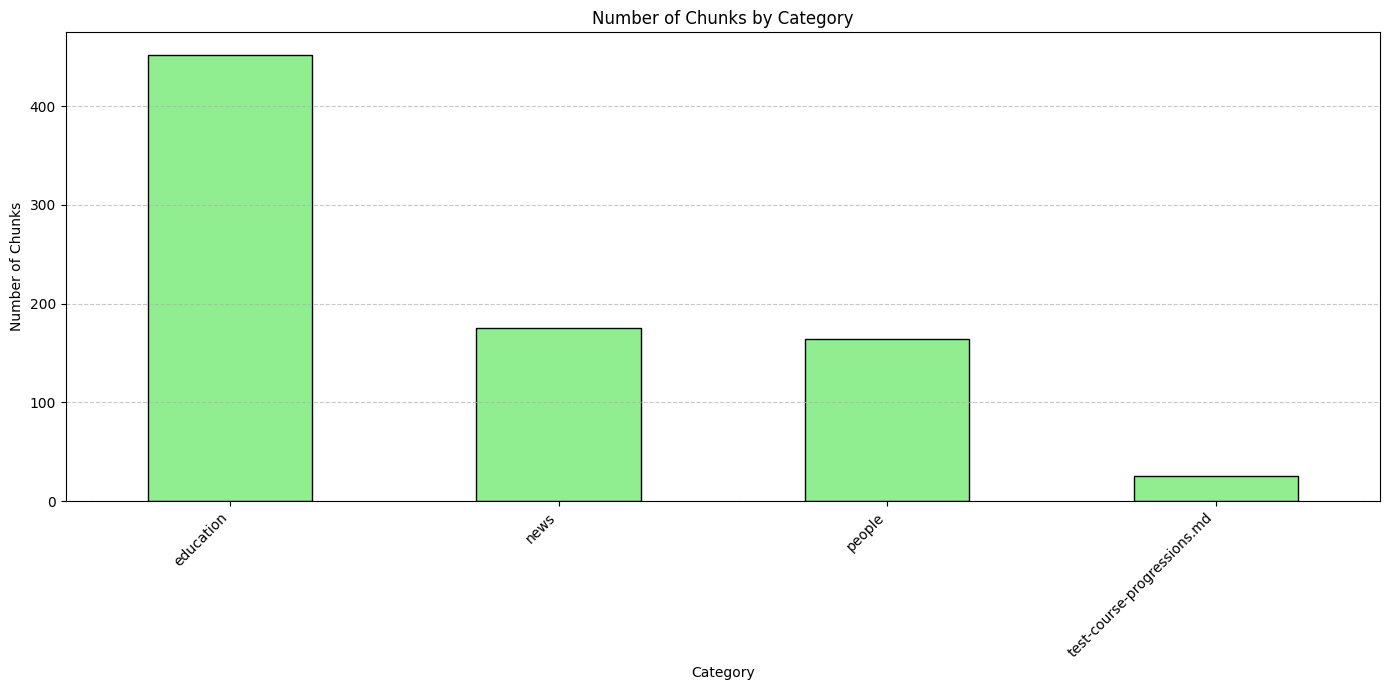

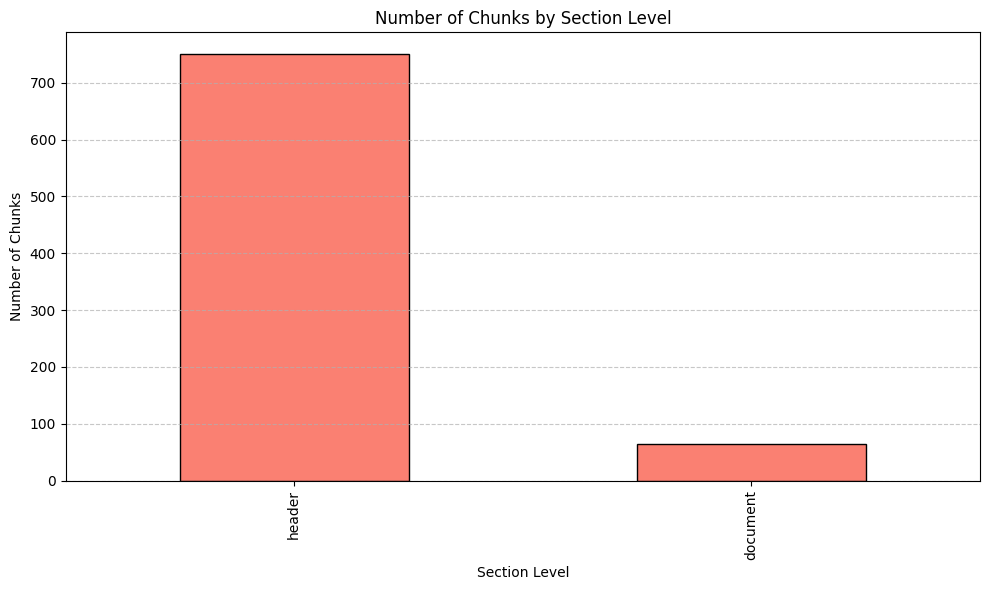

2025-05-12 17:54:55,750 - INFO - 2616926972 - <module> - 
Sample of chunk statistics:


,length,category,section_level,header_level
0,142,education,header,0
1,929,education,header,0
2,29,education,header,0
3,43,education,header,0
4,247,education,header,0


2025-05-12 17:54:55,753 - INFO - 2616926972 - <module> - --- Header-Based Chunking Process Completed in 0.53 seconds ---
2025-05-12 17:54:55,753 - INFO - 2616926972 - <module> - Processed 79 files and created 816 chunks


In [100]:
# Execute the chunking process
logger.info("--- Starting Header-Based Markdown Chunking Process ---")
start_time = time.time()

# Check input directory exists
if not Path(INPUT_MARKDOWN_DIR).exists():
    logger.error(f"Input directory '{INPUT_MARKDOWN_DIR}' does not exist.")
else:
    # Process all markdown files
    files_processed, chunks_created = process_markdown_directory(
        INPUT_MARKDOWN_DIR,
        OUTPUT_CHUNKS_DIR
    )
    
    # Analyze results if chunks were created
    if chunks_created > 0:
        all_chunks_file = Path(OUTPUT_CHUNKS_DIR) / "all_chunks_by_header_v2.json"
        chunks_df = analyze_chunks(all_chunks_file)
        
        if chunks_df is not None:
            logger.info("\nSample of chunk statistics:")
            display(chunks_df.head())

end_time = time.time()
logger.info(f"--- Header-Based Chunking Process Completed in {end_time - start_time:.2f} seconds ---")
logger.info(f"Processed {files_processed} files and created {chunks_created} chunks")

## Output Format

The chunks generated by this notebook are saved in JSON format and have the following structure:

```json
[
  {
    "page_content": "## Header Text\n\nActual content under this header...",
    "metadata": {
      "title": "Document Title",
      "category": "education",
      "date": "2025-05-04",
      "source_file": "path/to/original/file.md",
      "filename": "file.md",
      "section_level": "main",
      "section": "Main Section",
      "subsection": null,
      "header_level": 2,
      "header_text": "Header Text",
      "chunk_id": "filename_0",
      "document_title": "Document Title"
    }
  },
  // More chunks...
]
```

This format is compatible with most vector stores and can be directly used for embedding generation.

In [101]:
from pathlib import Path
print("v1 exists:", Path("../data/chunks/all_chunks_by_header.json").exists())
print("v2 exists:", Path("../data/chunks_v2/all_chunks_by_header.json").exists())

v1 exists: True
v2 exists: False


In [103]:
import json, statistics, tiktoken, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path

# point to the two consolidated JSON files
chunkv2 = Path("../data/chunks_v2/all_chunks_by_header_v2.json")
chunkv1 = Path("../data/chunks/all_chunks_by_header.json")
assert chunkv2.exists() and chunkv1.exists(), "Run both splitters first!"

enc = tiktoken.encoding_for_model("gpt-3.5-turbo")


In [104]:
def load_sizes(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    file_sizes = defaultdict(list)
    for ch in data:
        src = Path(ch["metadata"]["source_file"]).name
        tok = len(enc.encode(ch["page_content"]))
        file_sizes[src].append(tok)
    return file_sizes

sizes_ours   = load_sizes(chunkv2)
sizes_theirs = load_sizes(chunkv1)

all_files = sorted(set(sizes_ours) | set(sizes_theirs))


In [105]:
def stats(toks):
    return {
        "chunks": len(toks),
        "mean":   statistics.mean(toks) if toks else 0,
        "p90":    statistics.quantiles(toks, n=10)[-1] if toks else 0,
        "max":    max(toks) if toks else 0,
        "%>400":  100*sum(t>400 for t in toks)/len(toks) if toks else 0,
    }

rows = []
for fn in all_files:
    a = stats(sizes_ours.get(fn, []))
    b = stats(sizes_theirs.get(fn, []))
    rows.append({
        "file": fn,
        **{f"A_{k}": v for k,v in a.items()},
        **{f"B_{k}": v for k,v in b.items()},
    })

cmp_df = pd.DataFrame(rows).sort_values("file")
display(cmp_df.head())


,file,A_chunks,A_mean,A_p90,A_max,A_%>400,B_chunks,B_mean,B_p90,B_max,B_%>400
0,education_masters-programs_in-person-program.md,40,99.450000,181.9,255,0.0,14,280.714286,1007.0,1454,21.428571
1,education_masters-programs_ms-in-applied-data-...,9,83.333333,161.0,161,0.0,9,83.333333,161.0,161,0.000000
2,education_masters-programs_ms-in-applied-data-...,11,75.454545,183.6,195,0.0,4,208.000000,341.0,322,0.000000
3,education_masters-programs_ms-in-applied-data-...,3,82.000000,259.4,176,0.0,2,35.000000,39.8,37,0.000000
4,education_masters-programs_ms-in-applied-data-...,58,62.068966,101.0,205,0.0,4,900.750000,1862.0,1774,50.000000


In [106]:
agg = {
    "   metric": ["chunks", "mean", "p90", "max", "%>400"],
    "chunks_v2": [cmp_df[f"A_{m}"].mean() for m in ["chunks","mean","p90","max","%>400"]],
    "chunks_v1_avg":[cmp_df[f"B_{m}"].mean() for m in ["chunks","mean","p90","max","%>400"]],
}
display(pd.DataFrame(agg))


,metric,chunks_v2,chunks_v1_avg
0,chunks,10.329114,2.569620
1,mean,82.000584,356.875434
2,p90,229.484810,559.444304
3,max,174.962025,505.379747
4,%>400,0.000000,25.958409


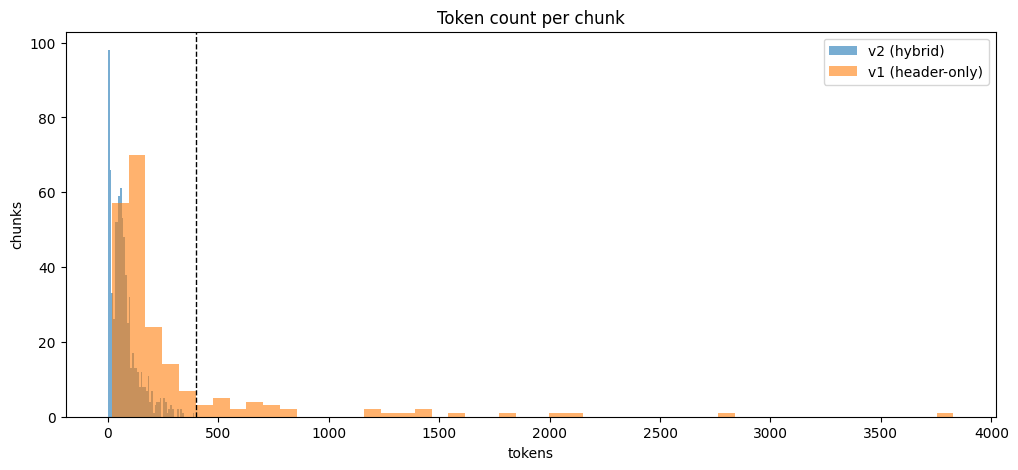

In [107]:
all_tok_v2   = [t for lst in sizes_ours.values()   for t in lst]
all_tok_v1 = [t for lst in sizes_theirs.values() for t in lst]

plt.figure(figsize=(12,5))
plt.hist(all_tok_v2,   bins=50, alpha=.6, label="v2 (hybrid)")
plt.hist(all_tok_v1, bins=50, alpha=.6, label="v1 (header-only)")
plt.axvline(400, color="k", ls="--", lw=1); plt.legend()
plt.title("Token count per chunk"); plt.xlabel("tokens"); plt.ylabel("chunks")
plt.show()


In [108]:
import json, tiktoken, statistics

enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

def token_stats(json_path):
    with open(json_path, "r") as f:
        chunks = json.load(f)
    tokens = [len(enc.encode(ch["page_content"])) for ch in chunks]
    return {
        "num_chunks": len(tokens),
        "mean_tokens": statistics.mean(tokens),
        "max_tokens": max(tokens),
        "chunks_over_400_tokens": sum(t > 400 for t in tokens),
    }

stats_hybrid = token_stats("../data/chunks_v2/all_chunks_by_header_v2.json")
stats_original = token_stats("../data/chunks/all_chunks_by_header.json")

print("Hybrid splitter stats:")
print(stats_hybrid)

print("\nOriginal splitter stats:")
print(stats_original)


Hybrid splitter stats:
{'num_chunks': 816, 'mean_tokens': 72.58333333333333, 'max_tokens': 392, 'chunks_over_400_tokens': 0}

Original splitter stats:
{'num_chunks': 203, 'mean_tokens': 281.1231527093596, 'max_tokens': 3828, 'chunks_over_400_tokens': 31}


This strategy is much safer. With 0% of chunks over 400 tokens and a mean of 82, it's well within the limits of virtually all common embedding models. This generally leads to better, more focused vector representations.